In [1]:
# Install necessary libraries
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install tikzplotlib
!pip install grape
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.7/323.7 kB 22.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setu

In [2]:
!nvidia-smi

Wed Sep 11 10:31:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
# basics
import numpy as np
import pandas as pd
import tensorflow as tf

# math
from math import ceil
from math import log
from math import log10

# utils
import itertools as it
import time
#from varname import nameof # get the name of a variable
import pickle
from tqdm.auto import tqdm, trange
#from tqdm import tqdm  RuntimeError: CUDA error: device-side assert triggered
import inspect
from grape.datasets.linqs import get_words_data # words information is excluded
import glob


# plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import tikzplotlib
#from barplots import barplots
import matplotlib.colors as colors
import seaborn as sns

# torch geometrics

import torch
import torch.optim as optim

from torch_geometric.datasets import FB15k_237
from torch_geometric.nn import ComplEx, DistMult, RotatE, TransE
from torch_geometric.data import Data

import os.path as osp

# Convolutional GNN

import torch_geometric.transforms as T

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.utils import negative_sampling
from torch_geometric.loader import LinkNeighborLoader

from sklearn.metrics import roc_auc_score

2024-10-27 17:05:15.155150: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-27 17:05:15.205105: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-27 17:05:15.916627: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/khushboo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
from pyrdf2vec.graphs import KG
import pandas as pd
# Load graph
view=0
view_name='VIEW'+str(view)
results = pd.DataFrame()

# Load graph
view_path='/home/khushboo/VIEW'+str(view)+"/"

nodes_df = pd.read_pickle(view_path+"nodes.pkl")
edges_df = pd.read_pickle(view_path+"edges.pkl")

In [3]:
# TRAIN DATASET

nodes_df.to_csv(view_path+"nodes.csv", header=False, index=False, sep='\t')
edges_df.to_csv(view_path+"edges.csv", header=False, index=False, sep='\t')

In [4]:
nodes_df

,name,type
0,<http://www.ncbi.nlm.nih.gov/gene/114112>,Gene
1,<http://www.ncbi.nlm.nih.gov/gene/60674>,Gene
2,<http://purl.obolibrary.org/obo/CL_1000405>,Cell
3,<http://www.ncbi.nlm.nih.gov/gene/100527949>,Gene
4,<http://www.ncbi.nlm.nih.gov/gene/113523636>,Gene
...,...,...
83982,<http://purl.obolibrary.org/obo/UBERON_0001289>,Anatomy
83983,<http://purl.obolibrary.org/obo/UBERON_0012337>,Anatomy
83984,<http://www.ncbi.nlm.nih.gov/gene/56112>,Gene
83985,<http://purl.obolibrary.org/obo/MONDO_0006055>,Disease


In [9]:
edges_df

,subject,predicate,object,type
0,<https://www.mirbase.org/mature/MIMAT0004503>,<http://purl.obolibrary.org/obo/RO_0002428>,<http://www.ncbi.nlm.nih.gov/gene/51100>,Involved in regulation of
1,<https://www.mirbase.org/mature/MIMAT0015051>,<http://purl.obolibrary.org/obo/RO_0003302>,<http://purl.obolibrary.org/obo/MONDO_0003220>,Causes or contributes to condition
2,<https://www.mirbase.org/mature/MIMAT0021038>,<http://purl.obolibrary.org/obo/RO_0002428>,<http://www.ncbi.nlm.nih.gov/gene/26057>,Involved in regulation of
3,<https://www.mirbase.org/mature/MIMAT0016887>,<http://purl.obolibrary.org/obo/RO_0002428>,<http://www.ncbi.nlm.nih.gov/gene/152503>,Involved in regulation of
4,<https://www.mirbase.org/mature/MIMAT0003948>,<http://purl.obolibrary.org/obo/RO_0002428>,<http://www.ncbi.nlm.nih.gov/gene/166863>,Involved in regulation of
...,...,...,...,...
1682770,<https://www.mirbase.org/mature/MIMAT0000646>,<http://purl.obolibrary.org/obo/RO_0002428>,<http://www.ncbi.nlm.nih.gov/gene/55274>,Involved in regulation of
1682771,<https://www.mirbase.org/mature/MIMAT0000682>,<http://purl.obolibrary.org/obo/RO_0002428>,<http://www.ncbi.nlm.nih.gov/gene/3185>,Involved in regulation of
1682772,<https://www.mirbase.org/mature/MIMAT0000090>,<http://purl.obolibrary.org/obo/RO_0002428>,<http://www.ncbi.nlm.nih.gov/gene/1824>,Involved in regulation of
1682773,<https://www.mirbase.org/mature/MIMAT0028115>,<http://purl.obolibrary.org/obo/RO_0002428>,<http://www.ncbi.nlm.nih.gov/gene/23326>,Involved in regulation of


In [5]:
# One-hot encoding of the types
class TypeOneHotEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), len(mapping))
        for i, col in enumerate(df.values):
            for type in col.split(self.sep):
                x[i, mapping[type]] = 1
        return x

# Integer encoding for types
class TypeIntegerEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), 1)
        for i, type in enumerate(df.values):
                x[i] = mapping[type]
        return x.to(torch.float)

In [6]:
def load_node_df(df, index_col, encoders=None, **kwargs):

    # Integer encoding for the types
    type_mapping: Dict[str, int] = {}

    df = df.set_index(index_col)
    # Create te mapping for the index
    mapping = {index: i for i, index in enumerate(df.index.unique())}

    # Create the features for the nodes
    x = None
    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]
        x = torch.cat(xs, dim=-1)

    return x, mapping

def load_edge_df(df, src_index_col, src_mapping, dst_index_col, dst_mapping,
                 pred_index_col=None, pred_mapping=None, encoders=None, **kwargs):

    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])

    # Edge Types
    edge_attr = None
    # Edge mapping
    if pred_mapping is not None:
        edge_attrs = torch.zeros(len(df), 1)
        for i, type in enumerate(df[pred_index_col].values):
            edge_attrs[i] = pred_mapping[type]
        edge_attr = edge_attrs.to(torch.int64)
    # No mapping but encoder
    if encoders is not None:
        edge_attrs = [encoder(df[col]) for col, encoder in encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)

    return edge_index, edge_attr

In [7]:
# Train

nodes_x, node_mapping = load_node_df(nodes_df, index_col='name',
                                     encoders={'type': TypeIntegerEncoder()}
                                    )

# Edge type mapping (same for train/test)
pred_mapping = {index: i for i, index in enumerate(edges_df.predicate.unique())}

edge_index, edge_type = load_edge_df(
    edges_df,
    src_index_col='subject', src_mapping = node_mapping,
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()
     #     }
    )

In [14]:
data = Data(x=nodes_x, edge_index=edge_index, edge_type=edge_type)

# For this, we first split the set of edges into
# training (80%), validation (10%), and testing edges (10%).
# Across the training edges, we use 70% of edges for message passing,
# and 30% of edges for supervision.
# We further want to generate fixed negative edges for evaluation with a ratio of 2:1.
# Negative edges during training will be generated on-the-fly, so we don't want to
# add them to the graph right away.
# Overall, we can leverage the `RandomLinkSplit()` transform for this from PyG:
from torch_geometric.transforms import RandomLinkSplit
transform = RandomLinkSplit()

train_data, val_data, test_data = transform(data)

train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

In [15]:
print(f"Edges Train: {len(train_data.edge_label_index[0])}  Test:{len(test_data.edge_label_index[0])}  Validation: {len(val_data.edge_label_index[0])}")

Edges Train: 2355886  Test:673110  Validation: 336554


In [16]:
## EXTERNAL TEST SETS

## VIEW 0-2
test_sets = ['miRNA-disease2bepred']
test_df = pd.read_csv(view_path+test_sets[0]+".txt", sep='\t')

## VIEW 3-5
#test_df = pd.read_csv(view_path+"miRNA-disease2bepred.txt", sep='\t')
#test_sets = ['miRNA-disease2bepred']
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 6-8
#test_df = pd.read_csv(view_path+"miRNA-gene2bepred.csv", sep='\t')
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 12-15 NO HEADERS!!
#test_df = pd.read_csv(view_path+"test.txt",names=["subject","predicate","object"], sep='\t')

In [17]:
test_df

,subject,predicate,object
0,<https://www.mirbase.org/mature/MIMAT0000062>,<http://purl.obolibrary.org/obo/RO_0003302>,<http://purl.obolibrary.org/obo/MONDO_0001056>
1,<https://www.mirbase.org/mature/MIMAT0000062>,<http://purl.obolibrary.org/obo/RO_0003302>,<http://purl.obolibrary.org/obo/MONDO_0002358>
2,<https://www.mirbase.org/mature/MIMAT0000062>,<http://purl.obolibrary.org/obo/RO_0003302>,<http://purl.obolibrary.org/obo/MONDO_0002691>
3,<https://www.mirbase.org/mature/MIMAT0000062>,<http://purl.obolibrary.org/obo/RO_0003302>,<http://purl.obolibrary.org/obo/MONDO_0003061>
4,<https://www.mirbase.org/mature/MIMAT0000062>,<http://purl.obolibrary.org/obo/RO_0003302>,<http://purl.obolibrary.org/obo/MONDO_0004948>
...,...,...,...
16907,<https://www.mirbase.org/hairpin/MI0014174>,<http://purl.obolibrary.org/obo/RO_0003302>,<http://purl.obolibrary.org/obo/MONDO_0005061>
16908,<https://www.mirbase.org/hairpin/MI0014206>,<http://purl.obolibrary.org/obo/RO_0003302>,<http://purl.obolibrary.org/obo/MONDO_0007256>
16909,<https://www.mirbase.org/hairpin/MI0016078>,<http://purl.obolibrary.org/obo/RO_0003302>,<http://purl.obolibrary.org/obo/MONDO_0007254>
16910,<https://www.mirbase.org/hairpin/MI0016888>,<http://purl.obolibrary.org/obo/RO_0003302>,<http://purl.obolibrary.org/obo/MONDO_0007256>


In [17]:
# Remove edges with unknown nodes
sources_in_graph = test_df.subject.apply(lambda x: x in nodes_df.name.values)
destinations_in_graph = test_df.object.apply(lambda x: x in nodes_df.name.values)

edge_extremes_in_graph = [a and b for a, b in zip(sources_in_graph, destinations_in_graph)]

print([[x,edge_extremes_in_graph.count(x)] for x in set(edge_extremes_in_graph)])

edges_to_predict_filtered = test_df[edge_extremes_in_graph]

test_edge_index, test_edge_type = load_edge_df(
    edges_to_predict_filtered,
    src_index_col='subject', src_mapping = node_mapping,
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()
     #     }
    )

external_test_data = Data(x=nodes_x,
                 edge_index=test_edge_index,
                 edge_type=test_edge_type,
                 edge_label_index=test_edge_index,
                 edge_label=torch.ones(test_edge_index.size(1))
                ).to(device)

[[False, 17], [True, 16895]]


In [10]:
edge_type_mapping = {index: i for i, index in enumerate(edges_df.predicate.unique())}

In [11]:
edge_type_mapping

{'<http://purl.obolibrary.org/obo/RO_0002428>': 0,
 '<http://purl.obolibrary.org/obo/RO_0003302>': 1,
 '<http://www.w3.org/2000/01/rdf-schema#subClassOf>': 2,
 '<http://purl.obolibrary.org/obo/RO_0004022>': 3,
 '<http://purl.obolibrary.org/obo/BFO_0000050>': 4,
 '<http://purl.obolibrary.org/obo/RO_0002162>': 5,
 '<http://purl.obolibrary.org/obo/RO_0002570>': 6,
 '<http://purl.obolibrary.org/obo/RO_0002314>': 7,
 '<http://purl.obolibrary.org/obo/RO_0000086>': 8,
 '<http://purl.obolibrary.org/obo/RO_0004026>': 9,
 '<http://purl.obolibrary.org/obo/RO_0002104>': 10,
 '<http://purl.obolibrary.org/obo/BSPO_0000098>': 11,
 '<http://purl.obolibrary.org/obo/mondo#predisposes_towards>': 12,
 '<http://purl.obolibrary.org/obo/RO_0000052>': 13,
 '<http://purl.obolibrary.org/obo/RO_0002573>': 14,
 '<http://purl.obolibrary.org/obo/RO_0000053>': 15,
 '<http://purl.obolibrary.org/obo/RO_0002387>': 16,
 '<http://purl.obolibrary.org/obo/RO_0000087>': 17,
 '<http://purl.obolibrary.org/obo/RO_0002211>': 18

In [18]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=8, concat=True)
        self.conv2 = GATConv(hidden_channels*8, out_channels, heads=1, concat=False)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()


model = Net(train_data.num_features, 4, 2).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

loader = LinkNeighborLoader(
    train_data,
    num_neighbors=[10] * 2,
    batch_size=4,
)

def train():
    model.train()
    optimizer.zero_grad()

    z = model.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )

    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss.item()


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

@torch.no_grad()
def get_prob(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return out.cpu().numpy()

@torch.no_grad()
def get_emb(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    return z.cpu().numpy()

best_val_auc = final_test_auc = 0

/home/khushboo/.local/lib/python3.10/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 8            |        cudaMalloc retries: 8         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   9575 MiB |  12260 MiB |  49349 MiB |  39774 MiB |\n|       from large pool |   9572 MiB |  12257 MiB |  49329 MiB |  39757 MiB |\n|       from small pool |      2 MiB |      4 MiB |     19 MiB |     16 MiB |\n|---------------------------------------------------------------------------|\n| Active memory         |   9575 MiB |  12260 MiB |  49349 MiB |  39774 MiB |\n|       from large pool |   9572 MiB |  12257 MiB |

In [19]:
# Training
n_epochs=25

for epoch in range(1, n_epochs):
    loss = train()
    torch.cuda.empty_cache()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 1.9680
Epoch: 002, Loss: 0.9384
Epoch: 003, Loss: 0.7154
Epoch: 004, Loss: 0.7279
Epoch: 005, Loss: 0.8255
Epoch: 006, Loss: 0.9409
Epoch: 007, Loss: 0.9591
Epoch: 008, Loss: 0.8887
Epoch: 009, Loss: 0.8035
Epoch: 010, Loss: 0.7477
Epoch: 011, Loss: 0.7218
Epoch: 012, Loss: 0.7143
Epoch: 013, Loss: 0.7189
Epoch: 014, Loss: 0.7314
Epoch: 015, Loss: 0.7453
Epoch: 016, Loss: 0.7531
Epoch: 017, Loss: 0.7499
Epoch: 018, Loss: 0.7379
Epoch: 019, Loss: 0.7233
Epoch: 020, Loss: 0.7112
Epoch: 021, Loss: 0.7033
Epoch: 022, Loss: 0.6995
Epoch: 023, Loss: 0.6988
Epoch: 024, Loss: 0.7001


In [20]:
# Training
n_epochs=50

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.7027
Epoch: 002, Loss: 0.7058
Epoch: 003, Loss: 0.7085
Epoch: 004, Loss: 0.7102
Epoch: 005, Loss: 0.7104
Epoch: 006, Loss: 0.7091
Epoch: 007, Loss: 0.7068
Epoch: 008, Loss: 0.7038
Epoch: 009, Loss: 0.7008
Epoch: 010, Loss: 0.6982
Epoch: 011, Loss: 0.6961
Epoch: 012, Loss: 0.6946
Epoch: 013, Loss: 0.6936
Epoch: 014, Loss: 0.6931
Epoch: 015, Loss: 0.6931
Epoch: 016, Loss: 0.6935
Epoch: 017, Loss: 0.6942
Epoch: 018, Loss: 0.6949
Epoch: 019, Loss: 0.6956
Epoch: 020, Loss: 0.6960
Epoch: 021, Loss: 0.6961
Epoch: 022, Loss: 0.6958
Epoch: 023, Loss: 0.6953
Epoch: 024, Loss: 0.6946
Epoch: 025, Loss: 0.6938
Epoch: 026, Loss: 0.6931
Epoch: 027, Loss: 0.6926
Epoch: 028, Loss: 0.6922
Epoch: 029, Loss: 0.6921
Epoch: 030, Loss: 0.6920
Epoch: 031, Loss: 0.6921
Epoch: 032, Loss: 0.6922
Epoch: 033, Loss: 0.6923
Epoch: 034, Loss: 0.6924
Epoch: 035, Loss: 0.6925
Epoch: 036, Loss: 0.6925
Epoch: 037, Loss: 0.6924
Epoch: 038, Loss: 0.6922
Epoch: 039, Loss: 0.6921
Epoch: 040, Loss: 0.6919


In [21]:
# Training
n_epochs=25

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6906
Epoch: 002, Loss: 0.6904
Epoch: 003, Loss: 0.6902
Epoch: 004, Loss: 0.6901
Epoch: 005, Loss: 0.6899
Epoch: 006, Loss: 0.6896
Epoch: 007, Loss: 0.6894
Epoch: 008, Loss: 0.6891
Epoch: 009, Loss: 0.6887
Epoch: 010, Loss: 0.6883
Epoch: 011, Loss: 0.6877
Epoch: 012, Loss: 0.6872
Epoch: 013, Loss: 0.6866
Epoch: 014, Loss: 0.6861
Epoch: 015, Loss: 0.6854
Epoch: 016, Loss: 0.6840
Epoch: 017, Loss: 0.6831
Epoch: 018, Loss: 0.6825
Epoch: 019, Loss: 0.6814
Epoch: 020, Loss: 0.6800
Epoch: 021, Loss: 0.6787
Epoch: 022, Loss: 0.6780
Epoch: 023, Loss: 0.6768
Epoch: 024, Loss: 0.6747


In [22]:
# Training
n_epochs=50

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6749
Epoch: 002, Loss: 0.6742
Epoch: 003, Loss: 0.6722
Epoch: 004, Loss: 0.6693
Epoch: 005, Loss: 0.6700
Epoch: 006, Loss: 0.6697
Epoch: 007, Loss: 0.6680
Epoch: 008, Loss: 0.6657
Epoch: 009, Loss: 0.6637
Epoch: 010, Loss: 0.6656
Epoch: 011, Loss: 0.6645
Epoch: 012, Loss: 0.6612
Epoch: 013, Loss: 0.6612
Epoch: 014, Loss: 0.6615
Epoch: 015, Loss: 0.6611
Epoch: 016, Loss: 0.6601
Epoch: 017, Loss: 0.6591
Epoch: 018, Loss: 0.6597
Epoch: 019, Loss: 0.6588
Epoch: 020, Loss: 0.6588
Epoch: 021, Loss: 0.6587
Epoch: 022, Loss: 0.6587
Epoch: 023, Loss: 0.6586
Epoch: 024, Loss: 0.6582
Epoch: 025, Loss: 0.6592
Epoch: 026, Loss: 0.6581
Epoch: 027, Loss: 0.6582
Epoch: 028, Loss: 0.6577
Epoch: 029, Loss: 0.6573
Epoch: 030, Loss: 0.6569
Epoch: 031, Loss: 0.6565
Epoch: 032, Loss: 0.6568
Epoch: 033, Loss: 0.6564
Epoch: 034, Loss: 0.6565
Epoch: 035, Loss: 0.6567
Epoch: 036, Loss: 0.6565
Epoch: 037, Loss: 0.6559
Epoch: 038, Loss: 0.6553
Epoch: 039, Loss: 0.6549
Epoch: 040, Loss: 0.6571


In [23]:
# Training
n_epochs=50

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6539
Epoch: 002, Loss: 0.6532
Epoch: 003, Loss: 0.6532
Epoch: 004, Loss: 0.6536
Epoch: 005, Loss: 0.6528
Epoch: 006, Loss: 0.6535
Epoch: 007, Loss: 0.6531
Epoch: 008, Loss: 0.6522
Epoch: 009, Loss: 0.6523
Epoch: 010, Loss: 0.6525
Epoch: 011, Loss: 0.6527
Epoch: 012, Loss: 0.6526
Epoch: 013, Loss: 0.6525
Epoch: 014, Loss: 0.6522
Epoch: 015, Loss: 0.6517
Epoch: 016, Loss: 0.6527
Epoch: 017, Loss: 0.6521
Epoch: 018, Loss: 0.6525
Epoch: 019, Loss: 0.6527
Epoch: 020, Loss: 0.6525
Epoch: 021, Loss: 0.6521
Epoch: 022, Loss: 0.6521
Epoch: 023, Loss: 0.6523
Epoch: 024, Loss: 0.6518
Epoch: 025, Loss: 0.6524
Epoch: 026, Loss: 0.6513
Epoch: 027, Loss: 0.6519
Epoch: 028, Loss: 0.6519
Epoch: 029, Loss: 0.6514
Epoch: 030, Loss: 0.6520
Epoch: 031, Loss: 0.6516
Epoch: 032, Loss: 0.6513
Epoch: 033, Loss: 0.6515
Epoch: 034, Loss: 0.6518
Epoch: 035, Loss: 0.6520
Epoch: 036, Loss: 0.6517
Epoch: 037, Loss: 0.6514
Epoch: 038, Loss: 0.6510
Epoch: 039, Loss: 0.6506
Epoch: 040, Loss: 0.6511


In [24]:
# Training
n_epochs=50

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6503
Epoch: 002, Loss: 0.6506
Epoch: 003, Loss: 0.6505
Epoch: 004, Loss: 0.6499
Epoch: 005, Loss: 0.6509
Epoch: 006, Loss: 0.6500
Epoch: 007, Loss: 0.6502
Epoch: 008, Loss: 0.6507
Epoch: 009, Loss: 0.6511
Epoch: 010, Loss: 0.6509
Epoch: 011, Loss: 0.6509
Epoch: 012, Loss: 0.6508
Epoch: 013, Loss: 0.6506
Epoch: 014, Loss: 0.6501
Epoch: 015, Loss: 0.6496
Epoch: 016, Loss: 0.6493
Epoch: 017, Loss: 0.6491
Epoch: 018, Loss: 0.6493
Epoch: 019, Loss: 0.6497
Epoch: 020, Loss: 0.6492
Epoch: 021, Loss: 0.6493
Epoch: 022, Loss: 0.6491
Epoch: 023, Loss: 0.6496
Epoch: 024, Loss: 0.6491
Epoch: 025, Loss: 0.6492
Epoch: 026, Loss: 0.6494
Epoch: 027, Loss: 0.6494
Epoch: 028, Loss: 0.6490
Epoch: 029, Loss: 0.6488
Epoch: 030, Loss: 0.6490
Epoch: 031, Loss: 0.6485
Epoch: 032, Loss: 0.6484
Epoch: 033, Loss: 0.6482
Epoch: 034, Loss: 0.6483
Epoch: 035, Loss: 0.6485
Epoch: 036, Loss: 0.6487
Epoch: 037, Loss: 0.6484
Epoch: 038, Loss: 0.6482
Epoch: 039, Loss: 0.6483
Epoch: 040, Loss: 0.6482


In [25]:
# Training
n_epochs=51

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6476
Epoch: 002, Loss: 0.6479
Epoch: 003, Loss: 0.6477
Epoch: 004, Loss: 0.6475
Epoch: 005, Loss: 0.6473
Epoch: 006, Loss: 0.6481
Epoch: 007, Loss: 0.6470
Epoch: 008, Loss: 0.6473
Epoch: 009, Loss: 0.6474
Epoch: 010, Loss: 0.6471
Epoch: 011, Loss: 0.6478
Epoch: 012, Loss: 0.6470
Epoch: 013, Loss: 0.6470
Epoch: 014, Loss: 0.6471
Epoch: 015, Loss: 0.6469
Epoch: 016, Loss: 0.6468
Epoch: 017, Loss: 0.6471
Epoch: 018, Loss: 0.6473
Epoch: 019, Loss: 0.6468
Epoch: 020, Loss: 0.6467
Epoch: 021, Loss: 0.6465
Epoch: 022, Loss: 0.6467
Epoch: 023, Loss: 0.6466
Epoch: 024, Loss: 0.6467
Epoch: 025, Loss: 0.6465
Epoch: 026, Loss: 0.6463
Epoch: 027, Loss: 0.6473
Epoch: 028, Loss: 0.6463
Epoch: 029, Loss: 0.6462
Epoch: 030, Loss: 0.6461
Epoch: 031, Loss: 0.6461
Epoch: 032, Loss: 0.6462
Epoch: 033, Loss: 0.6461
Epoch: 034, Loss: 0.6463
Epoch: 035, Loss: 0.6462
Epoch: 036, Loss: 0.6459
Epoch: 037, Loss: 0.6460
Epoch: 038, Loss: 0.6458
Epoch: 039, Loss: 0.6460
Epoch: 040, Loss: 0.6459


In [22]:
val_auc = test(val_data)
train_auc = test(train_data)
print(f' View: {view}, Train: {train_auc}, Val: {val_auc:.4f}')

 View: 0, Train: 0.9439416499802498, Val: 0.9411


In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, node_types):
    z = TSNE(n_components=2).fit_transform(h)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    unique_node_types = np.unique(node_types)
    palette = sns.color_palette("tab20", len(unique_node_types))

    # Create a dictionary mapping each node type to a color
    node_type_to_color = {node_type: palette[i] for i, node_type in enumerate(unique_node_types)}

    # Map the colors for each node based on its type
    node_colors = [node_type_to_color[node_type] for node_type in node_types]
    scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=node_colors, cmap="tab20")




    # Create legend manually
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
               for color in palette]
    plt.legend(handles, unique_node_types, title="Node Types", loc='best')
    plt.show()

In [32]:
z = get_emb(train_data)

In [33]:
z

array([[ 0.7396176 ,  0.54019976],
       [ 0.08642506, -0.06435239],
       [ 1.3161477 ,  1.0824366 ],
       ...,
       [ 0.76910836,  0.5703907 ],
       [-0.15136099, -0.12422593],
       [ 0.78516763,  0.58962625]], dtype=float32)

In [33]:
y= nodes_df['type'].astype('category').cat.codes

<ipython-input-37-33f9d704249d>:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=node_colors, cmap="tab20")


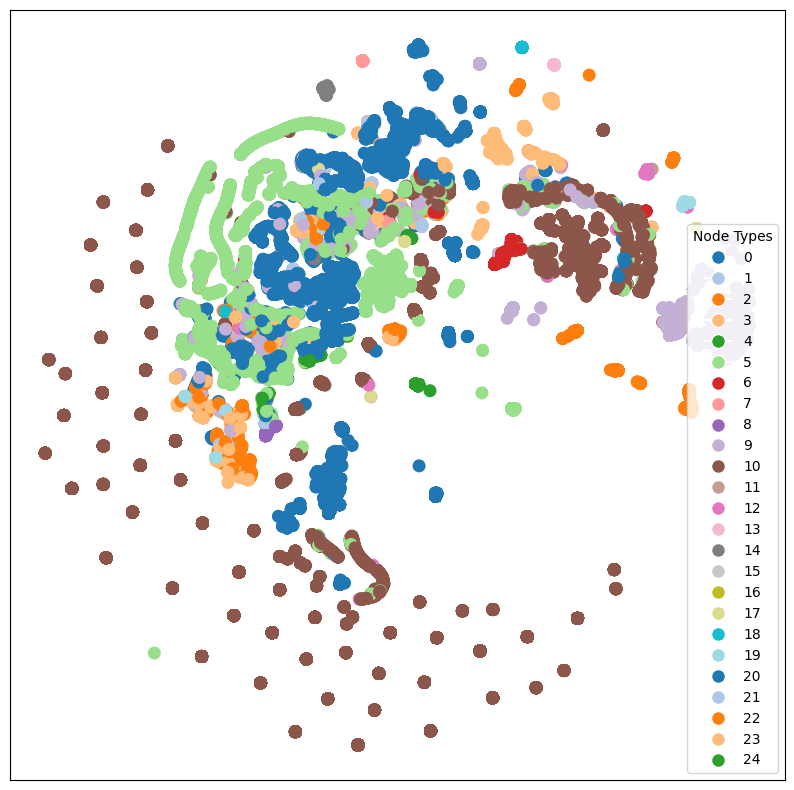

In [38]:
visualize(z,y)

In [40]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(nodes_df['type'])  # Convert the labels into numerical form

# Print the mapping of encoded values to original node types
print("Encoded Node Type Mapping:")
for i, node_type in enumerate(le.classes_):
    print(f"{i}: {node_type}")

Encoded Node Type Mapping:
0: Anatomy
1: Basic formal
2: Cell
3: Chemical
4: Chromosome
5: Disease
6: Environment
7: Environmental exposure
8: Food
9: GO
10: Gene
11: General medical science
12: Genomic feature
13: Human developmental stage
14: Medical action
15: Mental disease
16: Mental functioning
17: Mouse pathology
18: NCI thesaurus
19: Neuro behaviour
20: Phenotype
21: Protein
22: Species
23: Vaccine
24: miRNA


In [34]:
torch.save(model, view_path+'GATConv_model_view'+str(view)+'.pth')

In [16]:
model_path = view_path + 'GATConv_model_view' + str(view) + '.pth'
model = torch.load(model_path, map_location=torch.device('cpu'))

# Set the model to evaluation mode if you are using it for inference
model.eval()

<ipython-input-16-543e97dd2b58>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=torch.device('cpu'))


Net(
  (conv1): GATConv(1, 32, heads=8)
  (conv2): GATConv(256, 16, heads=1)
)

In [ ]:
import os

# Define the directory and file path
view =0
view_path = f'/content/drive/MyDrive/VIEW{view}/'
predictions_path = os.path.join(view_path, 'predictions')
file_path = os.path.join(predictions_path, f'view{view}_GATConv_node_embeddings.csv')

# Ensure the directory exists
os.makedirs(predictions_path, exist_ok=True)

In [ ]:
probs = edges_to_predict_filtered.copy()
probs['probability']=get_prob(external_test_data)
probs.to_csv(view_path+'predictions/view'+str(view)+'_GATConv_node_embeddings.csv')

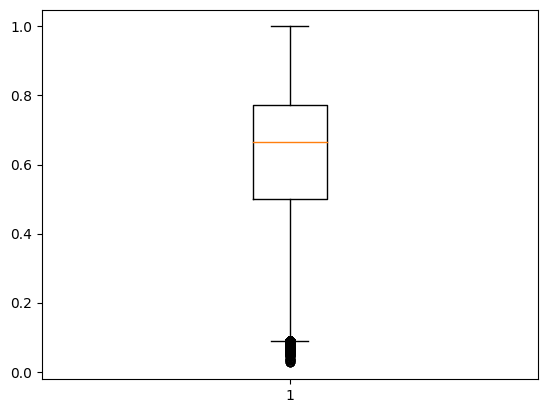

In [ ]:
_=plt.boxplot(get_prob(test_data))

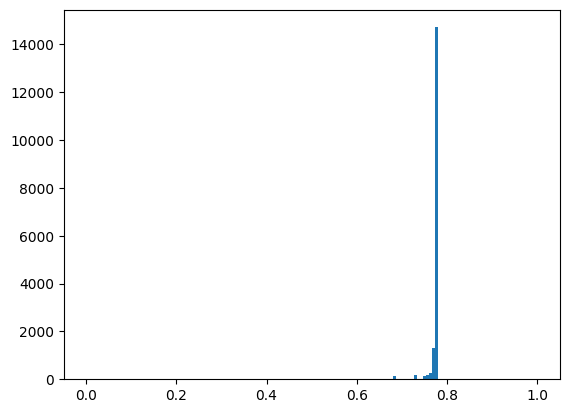

In [ ]:
_=plt.hist(get_prob(external_test_data), bins=150, range=[0,1])

In [ ]:
nodes_df

,name,type
0,<http://www.ncbi.nlm.nih.gov/gene/114112>,Gene
1,<http://www.ncbi.nlm.nih.gov/gene/60674>,Gene
2,<http://purl.obolibrary.org/obo/CL_1000405>,Cell
3,<http://www.ncbi.nlm.nih.gov/gene/100527949>,Gene
4,<http://www.ncbi.nlm.nih.gov/gene/113523636>,Gene
...,...,...
83982,<http://purl.obolibrary.org/obo/UBERON_0001289>,Anatomy
83983,<http://purl.obolibrary.org/obo/UBERON_0012337>,Anatomy
83984,<http://www.ncbi.nlm.nih.gov/gene/56112>,Gene
83985,<http://purl.obolibrary.org/obo/MONDO_0006055>,Disease


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Prepare the labels
true_labels = nodes_df['type']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Prepare the features and labels
X = z
y = true_labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision and recall
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.9833
Precision: 0.9833
Recall: 0.9833


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Set the minimum threshold for the number of nodes per class
min_samples = 5

# Count the frequency of each node type
node_type_counts = nodes_df['type'].value_counts()

# Filter out node types with fewer than the threshold
common_node_types = node_type_counts[node_type_counts >= min_samples].index

# Filter the data to keep only the common types
filtered_df = nodes_df[nodes_df['type'].isin(common_node_types)]
X_filtered = z[filtered_df.index]  # Embeddings corresponding to the filtered node types
true_labels_filtered = filtered_df['type']

# Encode the labels
le = LabelEncoder()
y_filtered = le.fit_transform(true_labels_filtered)  # Convert the labels into numerical form

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision, recall, and f1-score for each class (node type)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

# Print the overall accuracy
print(f"Overall Accuracy: {accuracy:.4f}")

# Print the precision, recall, and f1-score for each class
for i, class_label in enumerate(le.classes_):
    print(f"Class: {class_label}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1 Score: {f1[i]:.4f}")


Overall Accuracy: 0.9858
Class: Anatomy
  Precision: 0.9781
  Recall: 0.9765
  F1 Score: 0.9773
Class: Cell
  Precision: 0.9215
  Recall: 0.9026
  F1 Score: 0.9119
Class: Chemical
  Precision: 0.9257
  Recall: 0.9593
  F1 Score: 0.9422
Class: Chromosome
  Precision: 0.9579
  Recall: 0.9479
  F1 Score: 0.9529
Class: Disease
  Precision: 0.9892
  Recall: 0.9941
  F1 Score: 0.9916
Class: Environment
  Precision: 0.9833
  Recall: 0.9291
  F1 Score: 0.9555
Class: Environmental exposure
  Precision: 1.0000
  Recall: 0.9624
  F1 Score: 0.9808
Class: Food
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Class: GO
  Precision: 0.9702
  Recall: 0.9560
  F1 Score: 0.9631
Class: Gene
  Precision: 0.9920
  Recall: 0.9963
  F1 Score: 0.9941
Class: General medical science
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class: Genomic feature
  Precision: 0.9259
  Recall: 0.7576
  F1 Score: 0.8333
Class: Human developmental stage
  Precision: 1.0000
  Recall: 0.9167
  F1 Score: 0.9565
C

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
from grape import Graph
rna_kg_graph = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=False,
    name=view_name,
)

rna_kg_graph_directed = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=True,
    name=view_name+"_directed",
)

In [27]:
graph = rna_kg_graph_directed
# Function to simplify node names
def simplify_node_names(graph):
    simplified_node_names = [name[0] for name in graph.get_node_names()]
    return simplified_node_names

# Apply to the graph
simplified_node_names = simplify_node_names(graph)

In [35]:
from grape.edge_prediction import edge_prediction_evaluation
from grape.edge_prediction import DecisionTreeEdgePrediction, RandomForestEdgePrediction, ExtraTreesEdgePrediction, MLPEdgePrediction, GradientBoostingEdgePrediction,PerceptronEdgePrediction

evaluation = edge_prediction_evaluation(
    holdouts_kwargs=dict(train_size=0.8),
    graphs=graph,
    models=[RandomForestEdgePrediction()],
    number_of_holdouts=5,
    node_features=z,  # Use simplified embedding features
    smoke_test=False,
    enable_cache=False
)

Evaluating on VIEW0_directed:   0%|          | 0/5 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/329 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/329 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/329 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/329 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/329 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/329 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/329 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/329 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/329 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/329 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

In [36]:
results = pd.concat([results, evaluation], ignore_index = True)
filename = "results_"+view_name+"_FirstOrderLINE.csv"
results.to_csv(filename)

In [37]:
results

,evaluation_mode,train_size,validation_unbalance_rate,use_scale_free_distribution,negative_predictive_value,accuracy,diagnostic_odds_ratio,fall_out,positive_likelyhood_ratio,threat_score,...,"(model_parameters, max_features)","(model_parameters, max_leaf_nodes)","(model_parameters, min_impurity_decrease)","(model_parameters, bootstrap)","(model_parameters, oob_score)","(model_parameters, n_jobs)","(model_parameters, verbose)","(model_parameters, warm_start)","(model_parameters, ccp_alpha)","(model_parameters, max_samples)"
0,train,0.800001,1.0,True,0.518197,0.534003,3.382250,0.031709,3.144704,0.096650,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
1,test,0.800001,1.0,True,0.507378,0.514071,1.926193,0.032340,1.870176,0.058586,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
2,train,0.800001,1.0,True,0.515174,0.528114,2.376108,0.045487,2.236136,0.097290,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
3,test,0.800001,1.0,True,0.504795,0.509067,1.425186,0.045550,1.398108,0.060909,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
4,train,0.800001,1.0,True,0.514672,0.527139,2.259557,0.048003,2.130727,0.097597,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
5,test,0.800001,1.0,True,0.504194,0.507918,1.351993,0.048064,1.329500,0.060970,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
6,train,0.800001,1.0,True,0.514045,0.526024,2.216101,0.047533,2.094999,0.095063,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
7,test,0.800001,1.0,True,0.503625,0.506856,1.307806,0.047452,1.288979,0.058393,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
8,train,0.800001,1.0,True,0.514267,0.526412,2.225224,0.047946,2.101757,0.096160,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
9,test,0.800001,1.0,True,0.503653,0.506907,1.307657,0.047850,1.288686,0.058847,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None


In [30]:
from grape.edge_prediction import edge_prediction_evaluation
from grape.edge_prediction import DecisionTreeEdgePrediction, RandomForestEdgePrediction, ExtraTreesEdgePrediction, MLPEdgePrediction, GradientBoostingEdgePrediction,PerceptronEdgePrediction

# from grape.edge_prediction import KipfGCNEdgePrediction

# # Node Label prediction evaluation
from grape.node_label_prediction import node_label_prediction_evaluation
from grape.node_label_prediction import DecisionTreeNodeLabelPrediction, RandomForestNodeLabelPrediction, MLPNodeLabelPrediction, GradientBoostingNodeLabelPrediction#, PerceptronNodeLabelPrediction

In [34]:
evaluation = edge_prediction_evaluation(
    holdouts_kwargs=dict(train_size=0.8),
    graphs=graph,
    models=[DecisionTreeEdgePrediction()],
    number_of_holdouts=5,
    node_features=z,  # Use simplified embedding features
    smoke_test=False
)


In [35]:
results = evaluation
filename = "results_"+view_name+"_FirstOrderLINE_DesicionTree_gatconv.csv"
results.to_csv(filename)

In [36]:
# Separate train and test results
train_results = evaluation[evaluation['evaluation_mode'] == 'train']
test_results = evaluation[evaluation['evaluation_mode'] == 'test']

# Function to compute mean metrics for a given evaluation mode
def compute_mean_metrics(data):
    results = []
    for holdout in data['holdout_number'].unique():
        holdout_data = data[data['holdout_number'] == holdout]

        # Calculate mean values for metrics
        auc_score = holdout_data['auroc'].mean()
        precision = holdout_data['precision'].mean()
        recall = holdout_data['recall'].mean()
        f1_score = holdout_data['f1_score'].mean()
        accuracy = holdout_data['accuracy'].mean()  # Assuming 'accuracy' column exists

        # Append results for this holdout
        results.append({
            'Holdout': holdout,
            'AUC': auc_score,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score,
            'Accuracy': accuracy
        })

    # Convert to DataFrame
    return pd.DataFrame(results)

# Compute metrics for train and test
train_metrics_df = compute_mean_metrics(train_results)
test_metrics_df = compute_mean_metrics(test_results)

# Calculate overall mean for train and test
overall_train_mean = train_metrics_df.mean(numeric_only=True)
overall_test_mean = test_metrics_df.mean(numeric_only=True)

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Evaluation Mode': ['Train', 'Test'],
    'AUC': [overall_train_mean['AUC'], overall_test_mean['AUC']],
    'Precision': [overall_train_mean['Precision'], overall_test_mean['Precision']],
    'Recall': [overall_train_mean['Recall'], overall_test_mean['Recall']],
    'F1 Score': [overall_train_mean['F1 Score'], overall_test_mean['F1 Score']],
    'Accuracy': [overall_train_mean['Accuracy'], overall_test_mean['Accuracy']]
})

# Display the summary of mean metrics
print(summary_df)


  Evaluation Mode       AUC  Precision    Recall  F1 Score  Accuracy
0           Train  0.851578   0.650730  0.108314  0.185344  0.524685
1            Test  0.847917   0.544846  0.069973  0.123694  0.505467


In [37]:
test_results = evaluation[evaluation['evaluation_mode'] == 'test']

# Check if the filtering worked
print(test_results)

# List to store metrics for plotting
results = []

# Loop through each holdout for test results
for holdout in test_results['holdout_number'].unique():
    # Extract metrics for this holdout
    holdout_data = test_results[test_results['holdout_number'] == holdout]
    
    # Calculate mean values for the metrics
    auc_score = holdout_data['auroc'].mean()
    precision = holdout_data['precision'].mean()
    recall = holdout_data['recall'].mean()
    f1_score = holdout_data['f1_score'].mean()

    # Append results for this holdout
    results.append({
        'Holdout': holdout,
        'AUC': auc_score,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score
    })

# Create a DataFrame to summarize the filtered test results
results_df = pd.DataFrame(results)

# Print the results for test mode
print(results_df)

  evaluation_mode  train_size  validation_unbalance_rate  \
1            test    0.800001                        1.0   
1            test    0.800001                        1.0   
1            test    0.800001                        1.0   
1            test    0.800001                        1.0   
1            test    0.800001                        1.0   

   use_scale_free_distribution  miss_rate  positive_likelyhood_ratio  \
1                         True   0.933598                   1.242660   
1                         True   0.930929                   1.319147   
1                         True   0.936830                   1.248092   
1                         True   0.937006                   1.136539   
1                         True   0.911770                   1.058421   

   informedness  prevalence  accuracy  diagnostic_odds_ratio  ...  \
1      0.012967         0.5  0.506483               1.259919  ...   
1      0.016711         0.5  0.508355               1.342826  ...   

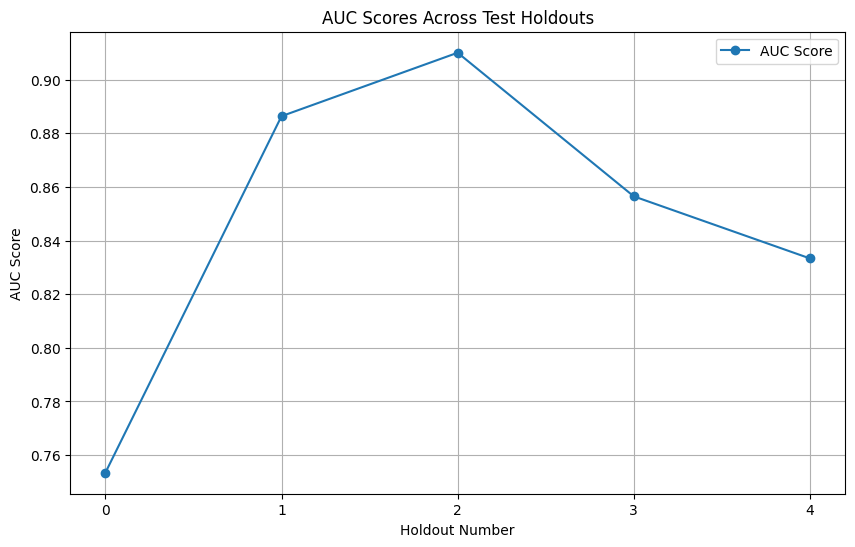

In [38]:
# Plotting AUC Scores for test mode
plt.figure(figsize=(10, 6))
plt.plot(results_df['Holdout'], results_df['AUC'], marker='o', label='AUC Score')
plt.title('AUC Scores Across Test Holdouts')
plt.xlabel('Holdout Number')
plt.ylabel('AUC Score')
plt.xticks(results_df['Holdout'])
plt.grid()
plt.legend()
plt.show()
